In [316]:
import sys
sys.path.append('./../../src')

# others shit
from matplotlib import pyplot

# my shit
from lib.stonk_jar import StonkJar

In [317]:
ticker = 'AAPL'
jar = StonkJar(ticker)
historical_pickle_name = "{0}.technical.historical.df.pkl".format(ticker)
data = jar.read_pickle_dataframe(historical_pickle_name)

In [318]:
len(data)
print(data.head())

                    ts           o           l           h           c   v  \
ts                                                                           
0  2020-11-01 05:00:00  122.631000  123.000000  123.282900  123.492000  32   
1  2020-11-01 06:00:00  123.182840  123.553500  123.837673  124.047714  69   
2  2020-11-01 07:00:00  123.737162  124.109491  124.394943  124.605929  34   
3  2020-11-01 08:00:00  124.293980  124.667983  124.954720  125.166655  37   
4  2020-11-01 09:00:00  124.853302  125.228989  125.041146  125.729905  23   

     e_a       e_e      r_ss       r_s       r_h      r_b      r_sb  
ts                                                                   
0   1.68  1.555857  0.023585  0.023585  0.221698  0.45283  0.278302  
1   1.68  1.555857  0.023585  0.023585  0.221698  0.45283  0.278302  
2   1.68  1.555857  0.023585  0.023585  0.221698  0.45283  0.278302  
3   1.68  1.555857  0.023585  0.023585  0.221698  0.45283  0.278302  
4   1.68  1.555857  0.023585  0.0

LTSM/Keras code below jacked shamelessly from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [319]:
# training params

n_features = 12

# number of samples to use to train in each round
# samples in this case are hourly tickers, so this is a 8hr trading day
n_samples = 8

# output 1 prediction
n_outputs = 1

# 5 days of trading data at a time
batch_size = n_samples * 5

In [320]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

data.index.name = 'ts'
values = data.values[:, 1:]
# integer encode direction
encoder = LabelEncoder()
# wtf is the 4 about? why 4?
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, n_outputs)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[6, 7, 8, 9, 10, 11, 12]], axis=1, inplace=True)
print(reframed.head())

    var1(t-8)  var2(t-8)  var3(t-8)  var4(t-8)  var5(t-8)  var6(t-8)  \
8    0.009413   0.009413   0.010341   0.009413   0.316327        0.0   
9    0.011658   0.011658   0.012596   0.011658   0.693878        0.0   
10   0.013913   0.013913   0.014862   0.013913   0.336735        0.0   
11   0.016178   0.016178   0.017138   0.016178   0.367347        0.0   
12   0.018454   0.018454   0.017490   0.018454   0.224490        0.0   

    var7(t-8)  var8(t-8)  var9(t-8)  var10(t-8)  ...   var3(t)   var4(t)  \
8         0.0        1.0        1.0         1.0  ...  0.021971  0.020987   
9         0.0        1.0        1.0         1.0  ...  0.022325  0.023284   
10        0.0        1.0        1.0         1.0  ...  0.021299  0.022259   
11        0.0        1.0        1.0         1.0  ...  0.022220  0.021235   
12        0.0        1.0        1.0         1.0  ...  0.024529  0.023534   

     var5(t)  var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  
8   0.612245      0.0      0.

In [321]:
# split into train and test sets
values = reframed.values
training_pct = 0.75
n_training = int(len(values) * 0.75)
train = values[:n_training, :]
test = values[n_training:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(47818, 8, 12) (47818,) (15940, 8, 12) (15940,)


>We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.
>
>We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
>
>The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).
>
>Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Epoch 1/50
1196/1196 - 8s - loss: 0.0293 - val_loss: 0.0452
Epoch 2/50
1196/1196 - 5s - loss: 0.0133 - val_loss: 0.0412
Epoch 3/50
1196/1196 - 5s - loss: 0.0114 - val_loss: 0.0101
Epoch 4/50
1196/1196 - 5s - loss: 0.0120 - val_loss: 0.0131
Epoch 5/50
1196/1196 - 5s - loss: 0.0091 - val_loss: 0.0103
Epoch 6/50
1196/1196 - 5s - loss: 0.0103 - val_loss: 0.0211
Epoch 7/50
1196/1196 - 5s - loss: 0.0070 - val_loss: 0.0198
Epoch 8/50
1196/1196 - 5s - loss: 0.0080 - val_loss: 0.0161
Epoch 9/50
1196/1196 - 5s - loss: 0.0078 - val_loss: 0.0099
Epoch 10/50
1196/1196 - 5s - loss: 0.0078 - val_loss: 0.0173
Epoch 11/50
1196/1196 - 5s - loss: 0.0077 - val_loss: 0.0068
Epoch 12/50
1196/1196 - 5s - loss: 0.0066 - val_loss: 0.0056
Epoch 13/50
1196/1196 - 6s - loss: 0.0070 - val_loss: 0.0076
Epoch 14/50
1196/1196 - 5s - loss: 0.0065 - val_loss: 0.0195
Epoch 15/50
1196/1196 - 5s - loss: 0.0086 - val_loss: 0.0183
Epoch 16/50
1196/1196 - 5s - loss: 0.0059 - val_loss: 0.0131
Epoch 17/50
1196/1196 - 5s - loss

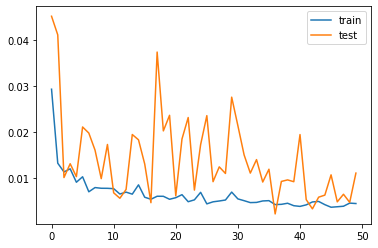

In [322]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_outputs))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [331]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X_pred = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_pred[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_pred = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_pred, test_X_pred[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.035
